#**Load MNIST Image Data and Fit Model**

In [29]:
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Epoch 1/12
469/469 [==============================] - 3s 5ms/step - loss: 0.2446 - accuracy: 0.9251 - val_loss: 0.0484 - val_accuracy: 0.9833
Epoch 2/12
469/469 [==============================] - 2s 4ms/step - loss: 0.0829 - accuracy: 0.9760 - val_loss: 0.0382 - val_accuracy: 0.9879
Epoch 3/12
469/469 [==============================] - 2s 4ms/step - loss: 0.0651 - accuracy: 0.9806 - val_loss: 0.0331 - val_accuracy: 0.9880
Epoch 4/12
469/469 [==============================] - 2s 4ms/step - loss: 0.0513 - accuracy: 0.9843 - val_loss: 0.0287 - val_accuracy: 0.9908
Epoch 5/12
469/469 [==============================] - 2s 4ms/step - loss: 0.0434 - accuracy: 0.9869 - val_loss: 0.0268 - val_accuracy: 0.9914
Epoch 6/12
469/469 [==============================] - 2s 4ms/step - loss: 0.0391 - accuracy: 0.9873 - val_loss: 0.0285 - val_accuracy: 0.9914
Epoch 7/12
469/469 [==============================] - 2s 4ms/step - loss: 0

#**Load LIME and Explain Predictions**

In [62]:
try:
  import lime
  from lime import lime_image
except ImportError as error:
  !pip install lime
  import lime 
  from lime import lime_image

import random
import numpy as np

predictions = model.predict(x_test)
print(predictions)

# The LIME ImageExplainer expects color images (3 channels) 
# We have grayscale here, so we need to make the images 'look' like RGB (replicating the grayscale values three times) so Lime will work with them.
def to_rgb(images):
    images_rgb = np.zeros((images.shape[0], images.shape[1], images.shape[2], 3))
    for i in range(3):
        images_rgb[..., i] = images[..., 0]
    return images_rgb

x_train_rgb = to_rgb(x_train)
x_test_rgb = to_rgb(x_test)

# We thus now also need to wrap the prediction function, to convert those 3-channel images back to 1 channel.
def new_predict(images):
  images = images[:,:,:,0].reshape(images.shape[0],images.shape[1],images.shape[2],1)
  predictions = model.predict(images)
  return predictions

[[6.4575128e-18 3.6278671e-11 3.4487305e-12 ... 1.0000000e+00
  1.1772137e-16 3.3528937e-11]
 [8.9500360e-16 1.0748381e-08 1.0000000e+00 ... 7.7960411e-14
  2.9014453e-14 2.8648937e-17]
 [3.1354780e-12 9.9999988e-01 2.6697625e-10 ... 3.2532075e-08
  7.0149722e-09 1.4065975e-10]
 ...
 [4.1019819e-19 4.2073598e-13 4.2203840e-15 ... 7.1303322e-14
  2.2691302e-12 7.4168553e-12]
 [1.1704023e-17 2.6134854e-17 3.2314639e-23 ... 1.6428674e-18
  6.7003534e-12 3.7135785e-16]
 [3.3108523e-13 1.7375480e-15 1.1160463e-12 ... 2.7103139e-19
  5.8360733e-13 1.8504916e-16]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Now we can visualize the explanation... this is obviously a pretty basic result - the model learns that raising the pixel values to the right of the two will increase the probability that it gets labeled a 2, where as increasing the pixel values on the left will decrease the probability its labeled a 2.

  0%|          | 0/1000 [00:00<?, ?it/s]

The rank ordering of most probable labels for this image is as follows: [4, 8, 9, 5, 6, 1, 2, 7, 0, 3].


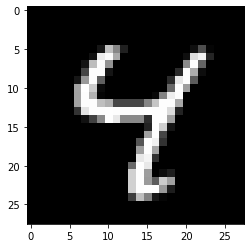

In [92]:
try:
  from skimage.segmentation import mark_boundaries
except ImportError as error:
  !pip install skimage 
  from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Instantiate our LIME explainer.
explainer = lime_image.LimeImageExplainer()

# Now use it to 'explain' the first test image.
explanation = explainer.explain_instance(x_test_rgb[6], new_predict, num_samples=1000, top_labels=10, hide_color=0)

print(f'The rank ordering of most probable labels for this image is as follows: {explanation.top_labels}.')

plt.imshow(x_test_rgb[6])
plt.show()

Now we can plot the super-pixels lime identified (boundaries are in yellow), and how they relate to the final prediction for each outcome class (the super-pixels it ends up considering are quite large, generally partitions of the original image). Gree means that super-pixel contributed positively to the label prediction, and red means it contributes negatively. That is, if you increase pixel values in that region, the associated label's prediction in the softmax gets larger for this image.

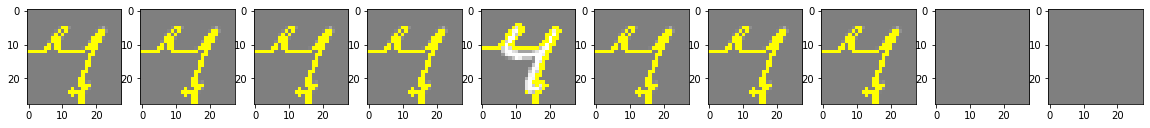

In [105]:
figure, axes = plt.subplots(nrows=1, ncols=10)

for i in range(10):
    # Get the 'temperature', i.e., the marginal effect of pixels, relative to each outcome label (there are 10)
    label = explanation.top_labels[i]
    # positive_only = True means we only display pixels that contributed positively to the respective label. Notice for most labels, the pixel contributions are basically 0.
    temp, mask = explanation.get_image_and_mask(label, positive_only=True, hide_rest=True)
    # Add a plot for the associated label 
    axes[label].imshow(mark_boundaries(temp / 2 + 0.5, mask))

figure.set_figheight(20)
figure.set_figwidth(20)